In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

In [3]:
def eshow(m, **kwargs): 
    pl=enplot.plot(m,downgrade=8,ticks=5, **kwargs)
    enplot.show(pl)

# File Loading

We specify the filepaths here. In the first cell, we load in a map which has the WCS and shape information, with which we will crop all other maps to fit. When we take power spectra, we want all of the maps involved to have the same shape and WCS!

In [15]:
data_dir = '/tigress/zequnl/cmb/data/emilie/'
point_source_mask_file = '/tigress/zequnl/cmb/data/masks/masks_20190416' + \
    '/mask_mr3c_s13s16_100mJy_10.0arcmin_ext_20190416.fits'
nsplits = 4

Next, we load in the maps and masks. In this example, the same mask is used to speed up the spectra calculation, but in general each map will have a different mask. We also apply the k-space filter at this step, with $|k_x| < 90$ and $|k_y| < 50$.

### Legacy Support
There is an important flag here, `legacy_steve = True`. At the time of this writing, Steve's code applies a slightly incorrect k-space filter, and offsets the maps by `(-1,-1)` in `WCS.CRPIX`.

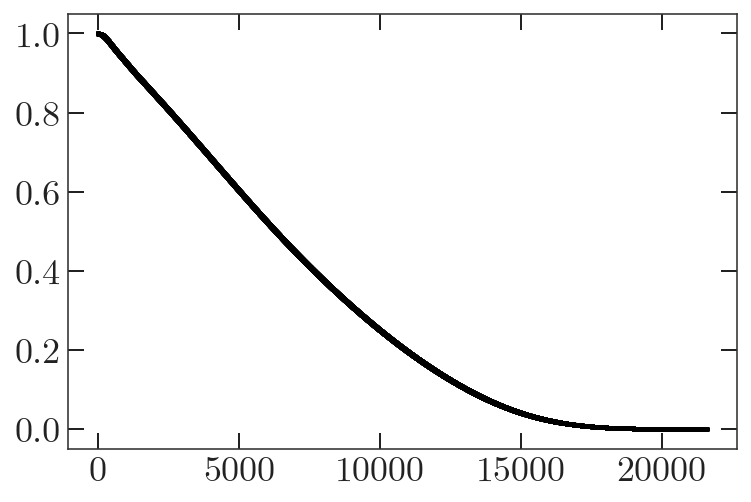

In [47]:
beam_file = f'{data_dir}/beam/mr3c_s15_pa2_f150_nohwp_night_beam_profile_jitter_cmb_181220.txt'
beam_t = np.loadtxt(beam_file)

import healpy as hp
Bl = hp.sphtfunc.beam2bl(
    beam_t[:,1], theta=beam_t[:,0]*np.pi/180.0, lmax=21600)
Bl /= np.max(Bl)
plt.plot(Bl)

We now load in sets of 4 of the following:
* I map
* inverse variance
* cross-linking

In [30]:
split_name = '/night/s15_boss_pa2_f150_nohwp_night_3pass_4way_set'

ps_mask = enmap.read_fits(point_source_mask_file)

map_I_list = [
    enmap.read_map(f'{data_dir}{split_name}{i}_map_srcfree.fits')[0]
             for i in range(nsplits)]
ivar_list = [
    enmap.read_map(f'{data_dir}{split_name}{i}_ivar.fits')
             for i in range(nsplits)]
xlink_list = [
    enmap.read_map(f'{data_dir}{split_name}{i}_xlink.fits')
             for i in range(nsplits)]

In [33]:
# have to get the point source mask into the same shape as the others
ps_mask = enmap.extract(ps_mask, map_I_list[0].shape, map_I_list[0].wcs)

Now we generate maps from each of these map lists that correspond to pixel weightings. It's time to make some arbitrary choices. 

1. We set a limit on $P_{\times} = \sqrt{Q^2 + U^2} / I$ of `0.8`, 
2. set a threshold on the noise of removing the worst 20 percentile 
3. multiply in the point source mask.
4. apodize by 10'

We multiply by the inverse variance and have a mask!

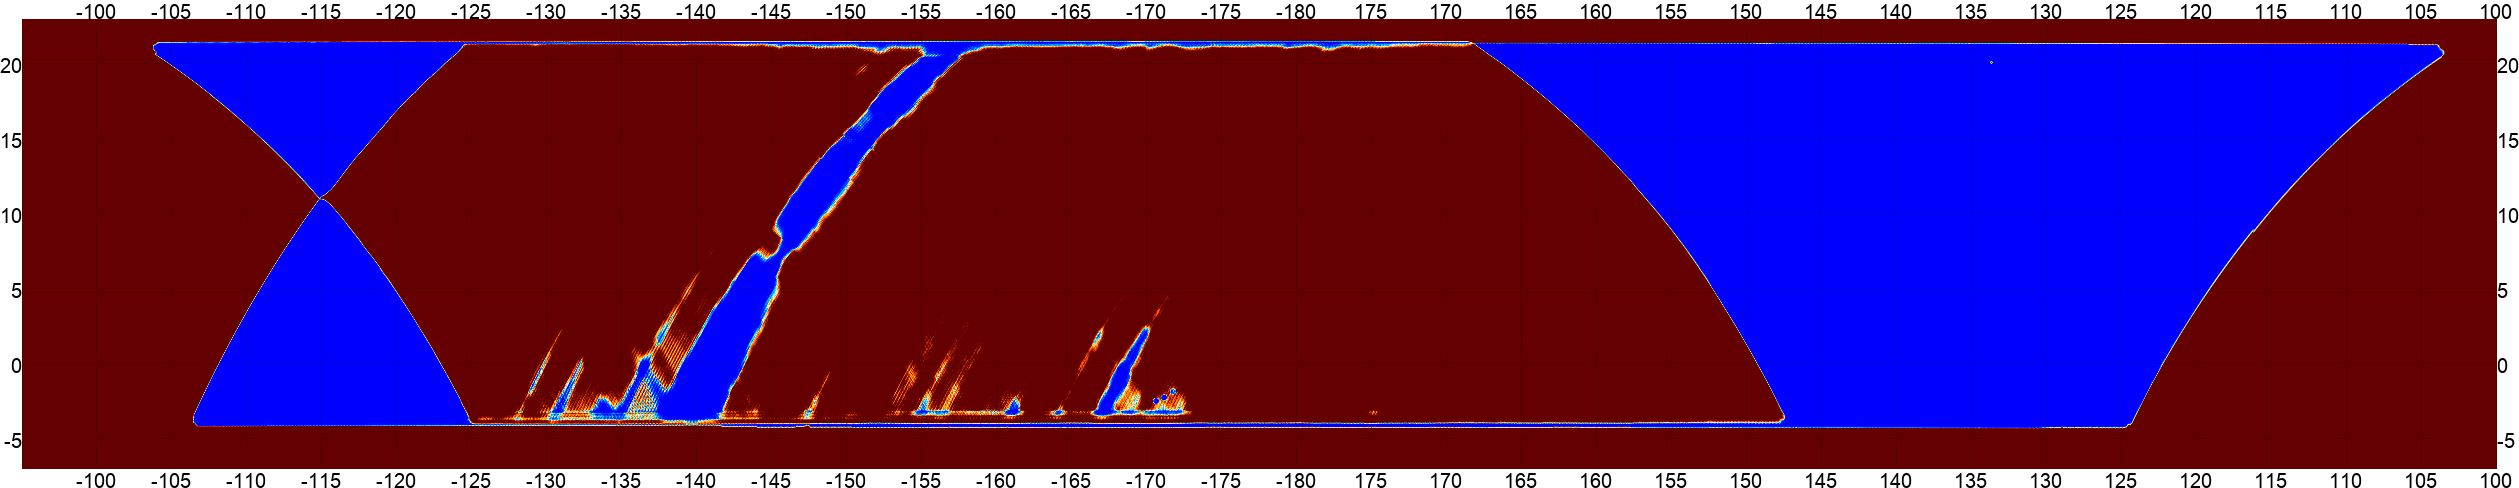

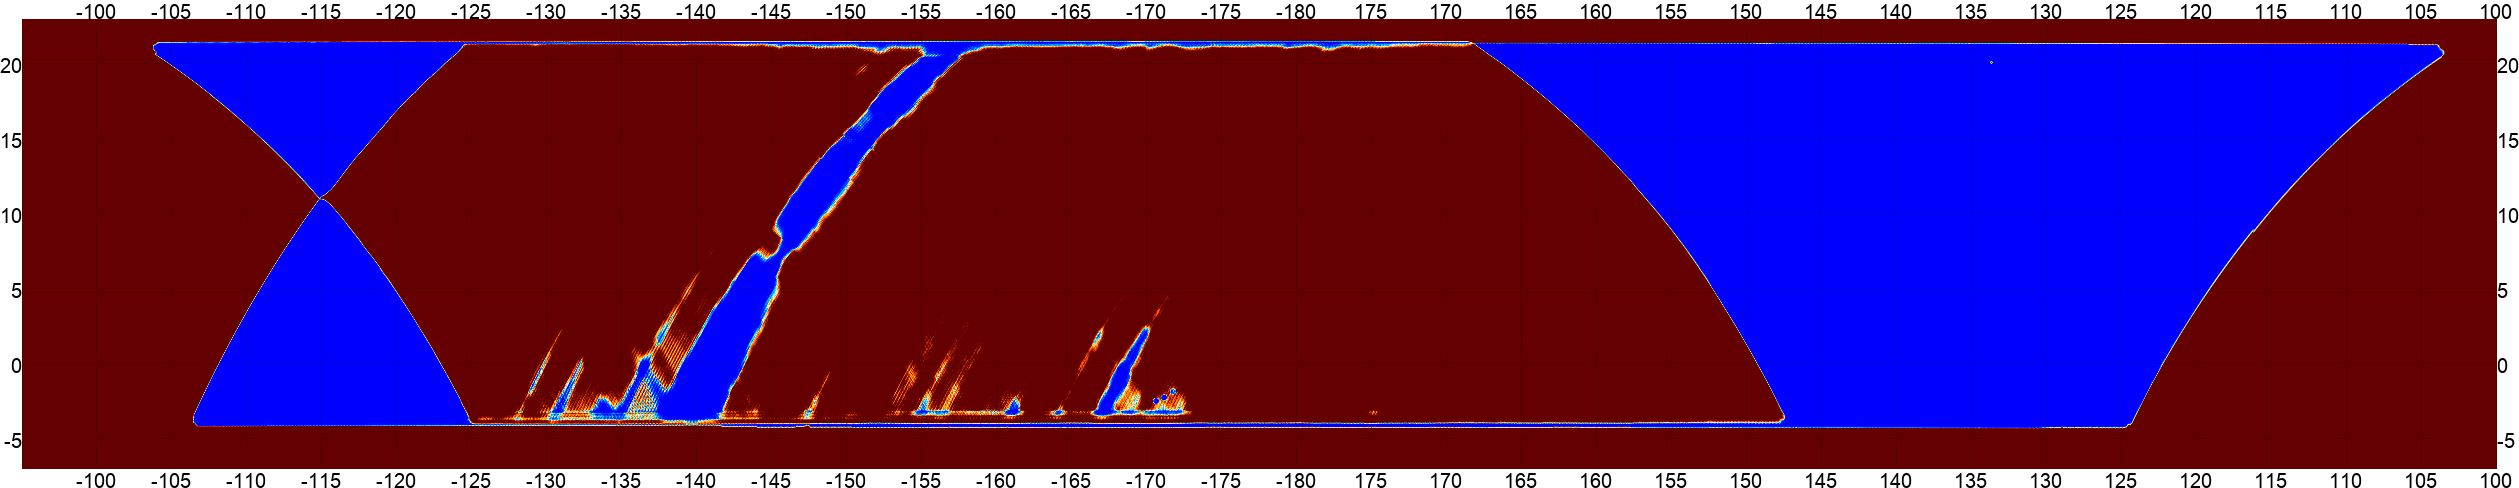

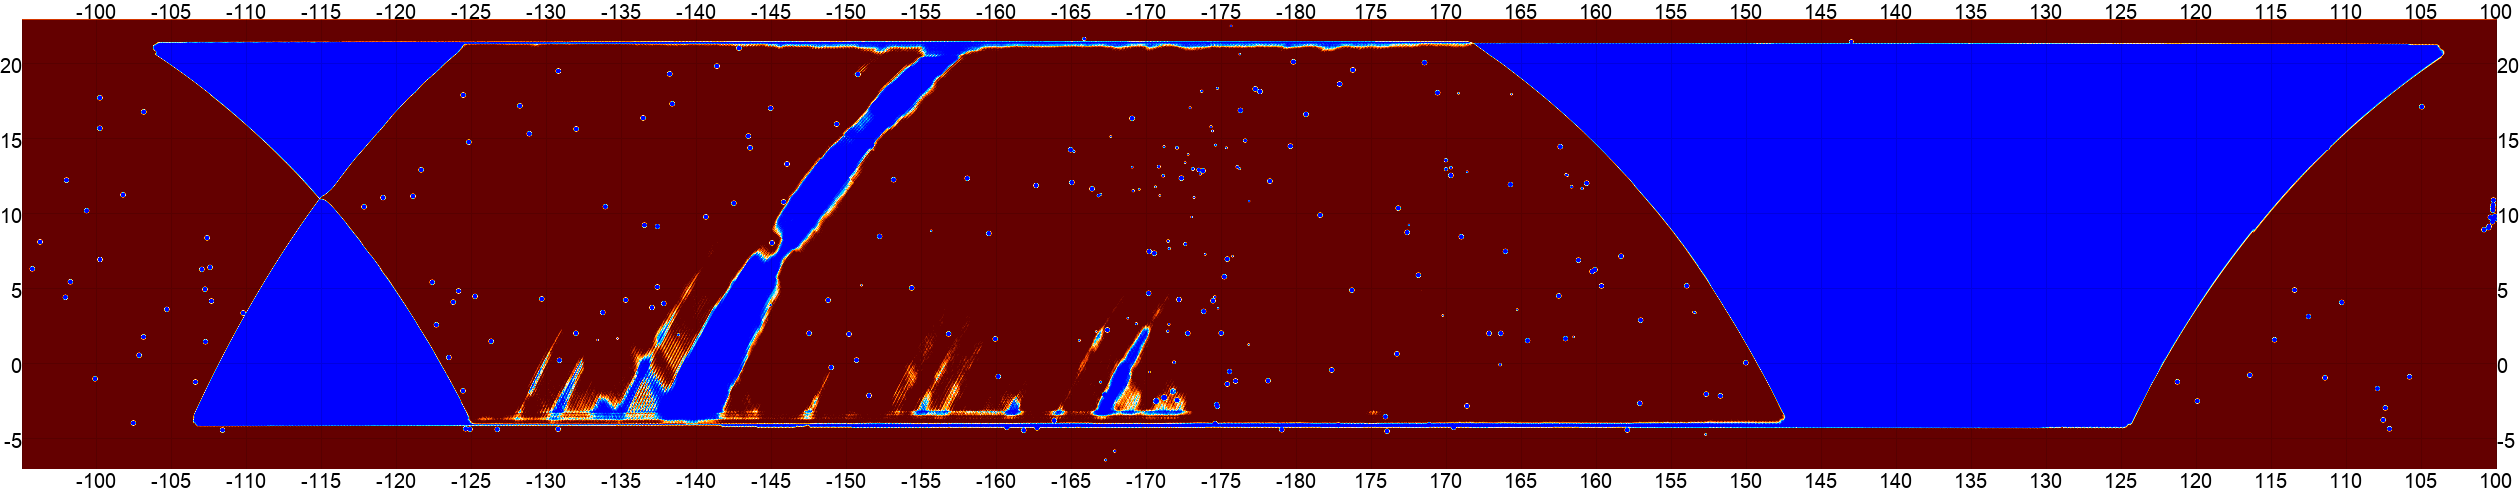

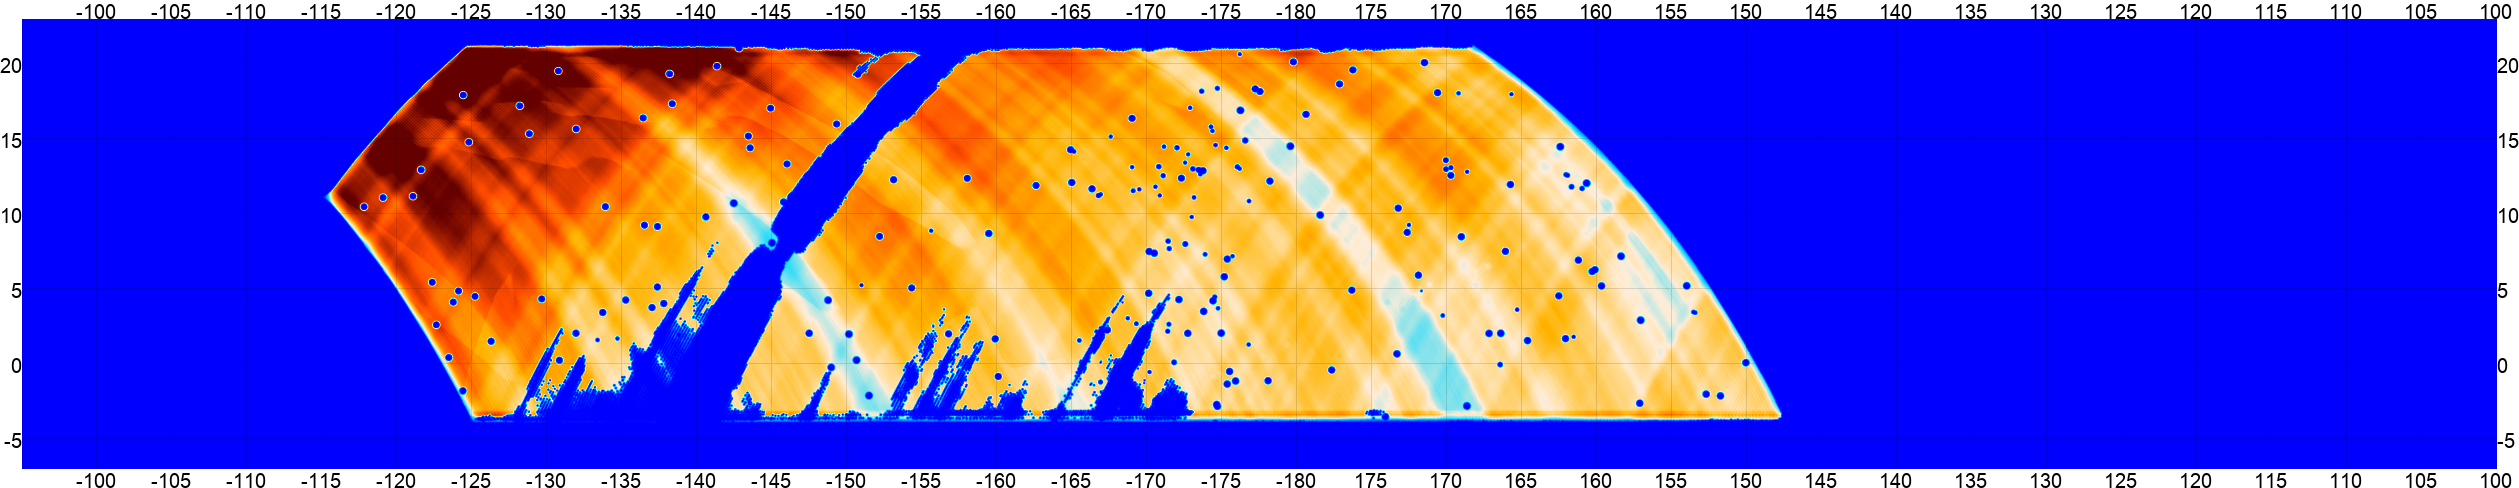

In [51]:
mask_list = []

for ind, ivar, xlink in zip(range(nsplits), ivar_list, xlink_list):
    
    # initialize the mask like the inverse variance
    mask = enmap.ones(ivar.shape, ivar.wcs)
    
    # we start with the cross-linking criteria
    I, Q, U = xlink
    I[I==0.0] = 1.0 # avoid dividing by zero. anywhere I=0, Q and U=0.
    Px = np.sqrt(Q**2 + U**2) / I
    mask[Px > 0.8] = 0.0
    
    if ind == 0: eshow(mask) # debug
        
    # next up, remove the worst 20% of the remaining inverse variance (high is good)
    cut = np.percentile(ivar[mask > 0.0], 20)
    mask[ivar < cut] = 0.0
    
    if ind == 0: eshow(mask) # debug
    
    # multiply in the point source mask
    mask *= ps_mask
    
    if ind == 0: eshow(mask) # debug
    
    # apodize, multiply in hits, we're done!
    mask = nw.apod_C2(mask, 10.0/60)
    mask *= ivar
    
    if ind == 0: eshow(mask) # debug
    mask_list.append(mask)

In [52]:
# loop over splits and generate 
namap_list = [
    nw.namap(
        map_I=map_I_list[i],
        mask=mask_list[i], 
        beam=Bl,
        legacy_steve=False,
        kx=90, ky=50)
    for i in range(nsplits)]

Next, we compute the mode coupling matrix from the first two fields. We will reuse this for all spectra calculations.

In [53]:
binfile = f'data/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.read_bins(binfile, is_Dell=True)

# WE NEED A NEW MODE COUPLING MATRIX EVERY TIME! CAN'T REUSE...
# mc = nw.mode_coupling(namap_list[0], namap_list[1], bins) 

Next, we apply the mode coupling matrix to each pair of `namap` objects. We will reuse the mode coupling object we computed, since all the masks are the same in this toy example. We take a flat mean of the 4 choose 2 = 6 cross spectra, and also compute the standard error.

In [ ]:
spec_dict = {}
TT_cross_spectra = []

for i in range(len(namap_list)):
    for j in range(len(namap_list)):
        if i >= j:
            Cb = nw.compute_spectra(
                namap_list[i], namap_list[j], bins=bins)
            for clXY in Cb:
                spec_dict[f"{clXY},{i},{j}"] = Cb[clXY]
            if i > j:
                TT_cross_spectra += [Cb['TT']]

mean_Cltt = np.sum(TT_cross_spectra, axis=0) / len(TT_cross_spectra)
se_Cltt = np.std(TT_cross_spectra, axis=0)/np.sqrt(len(TT_cross_spectra))

# Nighttime: Check Our Results

The night spectra should agree pretty well with Steve's reference spectra from s14 deep56.

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# plot steve spectra
specfile = f"/tigress/zequnl/cmb/data/from_choi/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01081284_output.txt"
choi_ell, choi_dl, choi_delta_dl, _ = np.loadtxt(specfile, unpack=True)[:,2:54]
axes[0].errorbar( choi_ell, choi_dl, yerr=choi_delta_dl, fmt='k.', 
                 lw=1, ms=1, label="Choi Reference Spectra" )
# plot our spectra
lbs = mc.lb[1:-3]
notebook_dl = mean_Cltt[1:-3] 
axes[0].errorbar(lbs + 10, notebook_dl, # we slightly offset to not overlap
                 fmt='r.', 
                 yerr=(notebook_dl / np.sqrt(2 * lbs + 1) + se_Cltt[1:-3]),
                 lw=1, ms=1, label="night")
axes[0].set_ylabel(r"$D_{\ell}$")
axes[0].legend(frameon=True)

# plot ratio
axes[1].axhline(0.0, ls='dashed', color='red')
axes[1].plot( lbs, (notebook_dl - choi_dl) / choi_delta_dl )
axes[1].set_ylabel('$ \Delta C_{\ell} / \sigma$')
axes[1].set_xlabel(r'$\ell$')
plt.tight_layout()

# Daytime (NOT UPDATED)

Now we can compute the daytime spectra. Since we used the same mask, we can re-use the mode coupling matrix.

In [ ]:
# loop over splits and generate 
nsplits = 4
day_namap_list = [nw.namap(map_I=enmap.read_map(f'/tigress/zequnl/cmb/data/emilie/day/s15_boss_pa2_f150_nohwp_day_3pass_4way_set{i}_map_srcfree.fits',)[0],
                       mask=mask, 
                       beam=Bl,
                       legacy_steve=False,
                       kx=90, ky=50)
              for i in range(nsplits)]

In [ ]:
day_spec_dict = {}
day_TT_cross_spectra = []

for i in range(len(namap_list)):
    for j in range(len(namap_list)):
        if i >= j:
            Cb = nw.compute_spectra(
                day_namap_list[i], day_namap_list[j], mc=mc)
            for clXY in Cb:
                day_spec_dict[f"{clXY},{i},{j}"] = Cb[clXY]
            if i > j:
                day_TT_cross_spectra += [Cb['TT']]
                
day_mean_Cltt = np.sum(day_TT_cross_spectra, axis=0) / len(day_TT_cross_spectra)
day_se_Cltt = np.std(day_TT_cross_spectra, axis=0)/np.sqrt(len(day_TT_cross_spectra))

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# plot steve spectra
specfile = f"/tigress/zequnl/cmb/data/from_choi/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01081284_output.txt"
choi_ell, choi_dl, choi_delta_dl, _ = np.loadtxt(specfile, unpack=True)[:,2:54]
axes[0].errorbar( choi_ell, choi_dl, yerr=choi_delta_dl, fmt='k.', 
                 lw=1, ms=1, label="Choi Reference s14 d56" )
# plot our spectra
lbs = mc.lb[1:-3]
notebook_dl = mean_Cltt[1:-3] 
day_notebook_dl = day_mean_Cltt[1:-3] 

axes[0].errorbar(lbs + 10, notebook_dl, # we slightly offset to not overlap
                 fmt='r.', 
                 yerr=(notebook_dl / np.sqrt(2 * lbs + 1) + se_Cltt[1:-3]),
                 lw=1, ms=1, label="night")

axes[0].errorbar(lbs + 10, day_notebook_dl, # we slightly offset to not overlap
                 fmt='b.', 
                 yerr=(day_notebook_dl / np.sqrt(2 * lbs + 1) + se_Cltt[1:-3]),
                 lw=1, ms=1, label="day")

axes[0].set_ylabel(r"$D_{\ell}$")
axes[0].legend(frameon=True)

# plot ratio
axes[1].axhline(0.0, ls='dashed', color='red')
axes[1].plot( lbs, (notebook_dl - choi_dl) / choi_delta_dl, color='r' )
axes[1].plot( lbs, (day_notebook_dl - choi_dl) / choi_delta_dl, color='b' )
axes[1].set_ylabel('$  (C_{\ell} - C_{\ell}^{ref}) / \sigma^{ref}$')
axes[1].set_xlabel(r'$\ell$')
plt.tight_layout()